# Alpha lifetime

An script to compute alpha lifetime.

In [688]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
import invisible_cities.core.system_of_units_c as SystemOfUnits
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running on  Sat Apr 15 18:19:01 2017


In [689]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-15 18:19:05


In [690]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [691]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

In [692]:
KDST = {3628:'LSC/kdst/3628/kdst_3628_full.h5', 3645:'LSC/kdst/3645/kdst_3645_1.h5'}

### Run Parameters

In [693]:
run_number = 3645

In [694]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [695]:
#ifile = os.path.join(os.environ['IC_DATA'],
#                        'LSC/kdst/{}/kdst_3628_full.h5'.format(run_number))

ifile = os.path.join(os.environ['IC_DATA'],KDST[3645])
                       
print("ifile:", ifile)

ifile: /Users/jjgomezcadenas/Projects/ICDATA/LSC/kdst/3645/kdst_3645_1.h5


In [696]:
full = load_dst(ifile)
print(len(full))
full.head()

21289


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,3,1.492202e+09,0,1,350.0,276.722809,1515.836656,531900.0,9.426875,11019.614258,...,654062.5,16,122.1625,122.1625,-21.497194,112.556617,114.591105,1.759514,8.018817,8.519045
1,4,1.492202e+09,0,1,325.0,241.455292,1415.866953,634600.0,4.767500,14362.279297,...,652437.5,18,17.8375,17.8375,100.035990,-137.599061,170.119666,-0.942171,8.840984,8.584587
2,5,1.492202e+09,0,1,350.0,242.239777,1455.815054,511650.0,9.163312,8109.848145,...,653862.5,14,142.2125,142.2125,107.072689,94.367245,142.722590,0.722408,7.784772,8.385585
3,6,1.492202e+09,0,1,300.0,313.980896,1775.244480,383825.0,10.691812,5046.355957,...,654862.5,13,271.0375,271.0375,45.982220,111.511962,120.620405,1.179687,8.719186,8.463334
4,8,1.492202e+09,0,1,300.0,274.860657,1514.563069,641400.0,5.188562,26482.410156,...,652562.5,23,11.1625,11.1625,-76.461523,76.361306,108.062082,2.356850,9.425307,9.171296


In [697]:
len(full)

21289

In [698]:
r = event_rate(full)

In [699]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 0.3579627234856339 evts/s


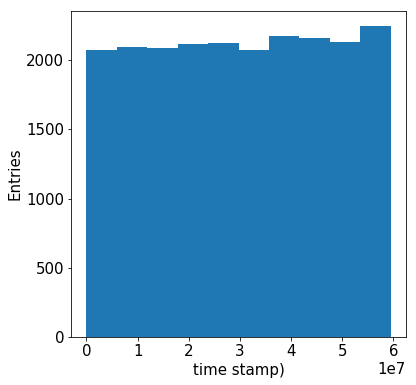

In [700]:
n, bins, patches = plt.hist(1e+3*(full.time - full.time[0]), 10)
labels("time stamp)", "Entries")

In [701]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

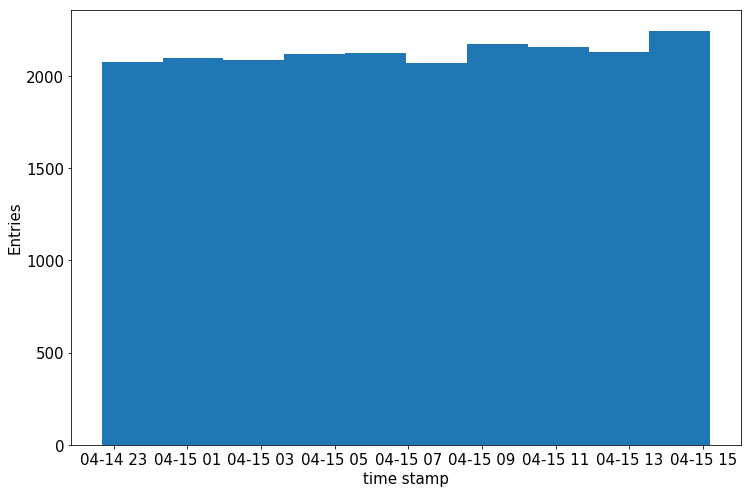

In [702]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(x, 10)
labels("time stamp", "Entries")

In [703]:
st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')

In [704]:
print(st)

2017-04-15 15:11:46


In [705]:
print(full.time.index[-1])

21288


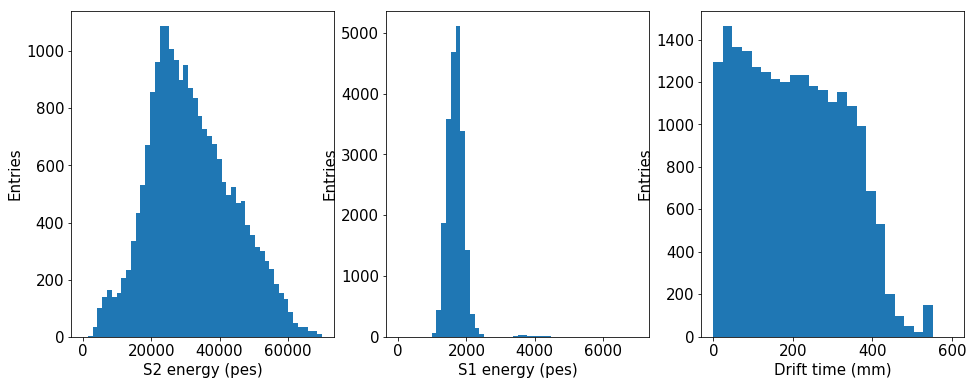

In [706]:
figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 2)
plt.hist(full.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(full.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")


### Dependence with Z all alphas

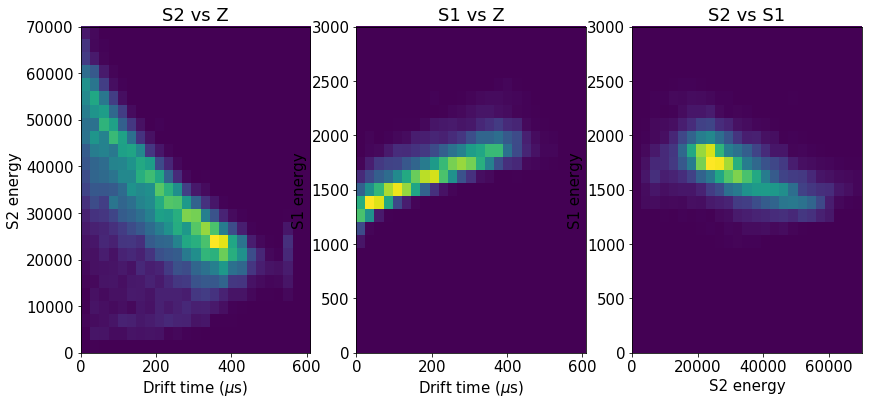

In [707]:
zrange =   0, 610
S2range = 0, 7e4
S1range = 0, 3e3

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')



### Fiducial volume

In [708]:
core = blk[blk.R < 100]
print("Ratio wrt full:", len(core)/len(full))

Ratio wrt full: 0.24035887077833623


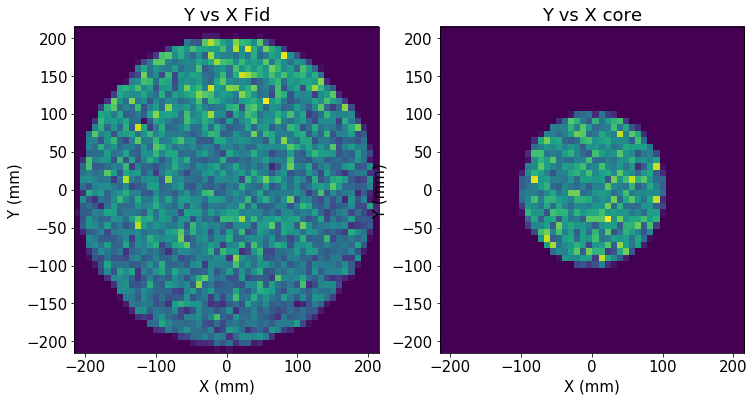

In [709]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

plt.hist2d(full.X, full.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X Fid')

ax = plt.subplot(1, 2, 2)

plt.hist2d(core.X, core.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

### Z correction for bulk 

#### S2

fit par[0] = 60342.31019281846 error = 234.4597139203374
fit par[1] = -429.78341734788705 error = 3.079147796151135
degrees of freedom = 2
chi2 = 1.540881669793491


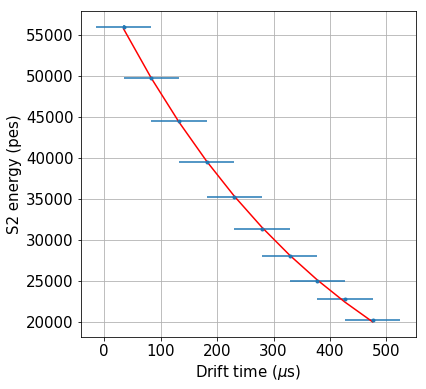

In [710]:
zrange =   10, 500
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

#### Constrain fiducial in z

In [711]:
cz = core[in_range(core.Z ,25, 525)]
print("Ratio wrt full:", len(cz)/len(full))

Ratio wrt full: 0.22809901827234721


#### Fit S2 in fiducial 

fit par[0] = 60361.01608760415 error = 291.13318589996794
fit par[1] = -429.05573120991994 error = 3.694589427532075
degrees of freedom = 2
chi2 = 1.2609088844134724


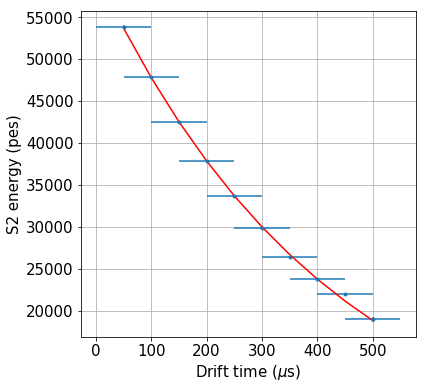

In [712]:
zrange =   25, 525
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(cz.Z, cz.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

### S2 corrections

In [713]:
st0 = time_from_timestamp(full.time[0])
st0 = time_from_timestamp(full.time[-1:])
print('t0 = {} t1 = {}'.format(st0,st1))

t0 = 2017-04-15 15:11:46 t1 = 2017-04-14 12:13:42


In [714]:
len(cz)

4856

using data set with length 4856
t0 = 2017-04-14 22:40:35 (index = 0) t1 = 2017-04-15 15:11:46 (index = 4856)
bin length = 971
 ---fit over events between 0 and 971
time0 = 2017-04-14 22:40:35 time1 = 2017-04-15 02:12:06
size of time leg = 971
fit par[0] = 61794.697028176095 error = 223.82601486517078
fit par[1] = -393.5363956343427 error = 2.015765475867727
degrees of freedom = 2
chi2 = 0.36705065151544697
 ---fit over events between 971 and 1942
time0 = 2017-04-15 02:12:06 time1 = 2017-04-15 05:40:40
size of time leg = 971
fit par[0] = 60954.93421947158 error = 642.0544716469967
fit par[1] = -424.709073832566 error = 7.556456837974455
degrees of freedom = 2
chi2 = 1.150527165103495
 ---fit over events between 1942 and 2913
time0 = 2017-04-15 05:40:40 time1 = 2017-04-15 08:53:00
size of time leg = 971
fit par[0] = 60465.36520703999 error = 671.2445197822809
fit par[1] = -438.4658943851316 error = 8.647820950562528
degrees of freedom = 2
chi2 = 1.1442109584955615
 ---fit over events bet

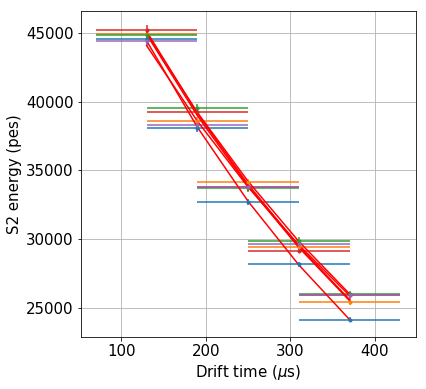

In [715]:
CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=cz, zrange=(100,400), Erange=(1e+3, 80e3), nbins=5)

In [716]:
plot_options()

In [717]:
TSTAMP

['2017-04-15 02:12:06',
 '2017-04-15 05:40:40',
 '2017-04-15 08:53:00',
 '2017-04-15 12:03:03',
 '2017-04-15 15:11:46']

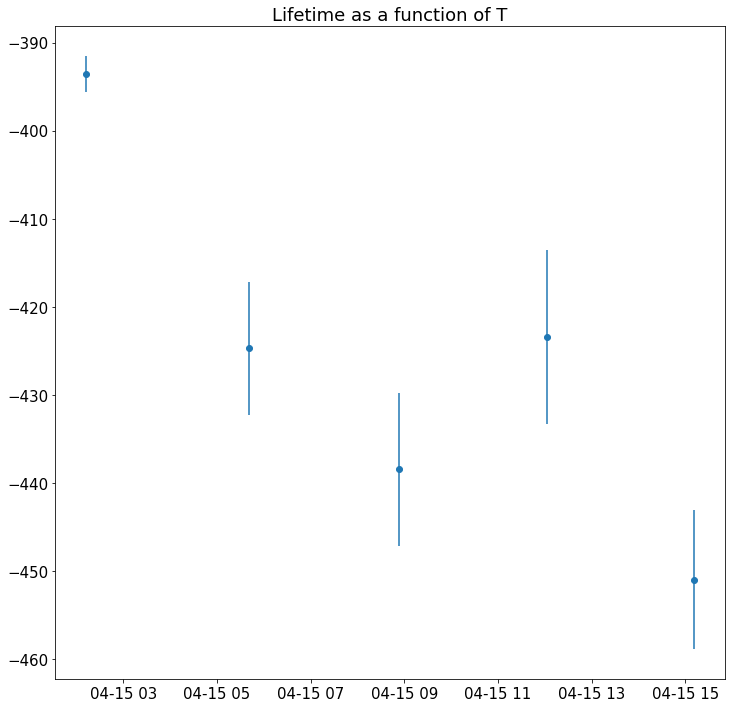

In [718]:
figsize=(12,12)
plt.figure(figsize=figsize)
plt.errorbar(TIME, LAMBDA, yerr=ELAMBDA, linestyle='none', fmt='o')
plt.title('Lifetime as a function of T')